In [4]:
%pylab notebook
#lib for widgets
import ipywidgets as widg
#importing our lib for binning and fitting
import binning
import fitting
from scipy import stats #need for chi2 statistics
from IPython.display import Latex

Populating the interactive namespace from numpy and matplotlib


# Manipulating data

We're writing below some code to enable interactivity in data binning. Once we will have defined the optimal binning size and width we will fix those parameters and use them for data fitting.


In [5]:
#Global variables
df           = None
R            = 502. #circuit resistance 
capacity_1   = 1.14739401756e-09
capacity_2   = 1.3277203496e-09
e_charge     = -1.60217653*10**(-19)

In [7]:
file_path = '../data/data_raw_area_calibration/160509009.txt' #005
df = binning.read_data(file_path, [0,2,3] , ['t','v_res','v_scheda']) #read the first three columns
binning.remove_offset(df,0.0002)  #Removing offset from signal
binning.amplify_data(df,[('v_scheda',7.41),('v_res',2)])
binning.calculate_data(df, R) #compute the current and v_probe

print('Loaded dataframe\n',df.head())

Loaded dataframe
           t     v_res  v_scheda  v_scheda_ampl  v_res_ampl   v_probe     i_raw
0  0.000000  0.022993  0.007324       0.054272    0.045987  0.008286  0.000092
1  0.000007  0.029097 -0.001221      -0.009045    0.058194 -0.067239  0.000116
2  0.000013  0.054732  0.002441       0.018091    0.109463 -0.091372  0.000218
3  0.000020  0.044966  0.004883       0.036182    0.089932 -0.053750  0.000179
4  0.000027  0.015669 -0.002441      -0.018091    0.031338 -0.049429  0.000062


<IPython.core.display.Javascript object>


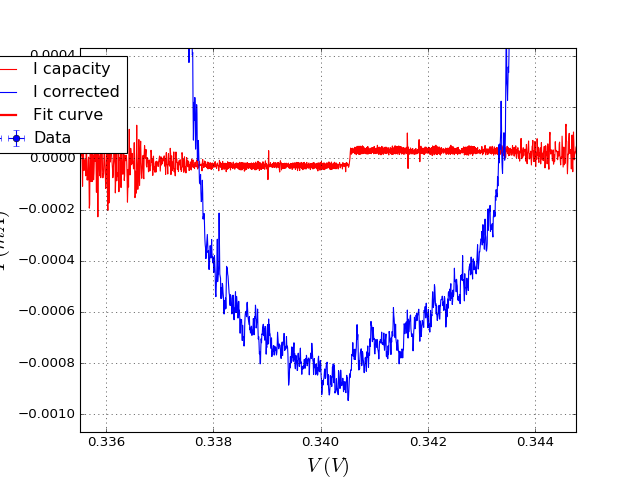

In [26]:
#calculate capacity correction
I_cap = (np.gradient(df.v_probe)/np.gradient(df.t)) * capacity_2
df['i'] = df['i_raw'] + I_cap
plt.figure()
plt.plot(df.t, I_cap,'r', label="I capacity")
plt.plot(df.t,df.i, 'b',label="I corrected")
plt.xlabel("Time (s)")
plt.ylabel("V (Volt)")
plt.grid()

plt.legend()

In [27]:
a,b,c,b1,b2, N_iterations = [-50,0,30,100,100, 50]  #default for zones and bin

<IPython.core.display.Javascript object>


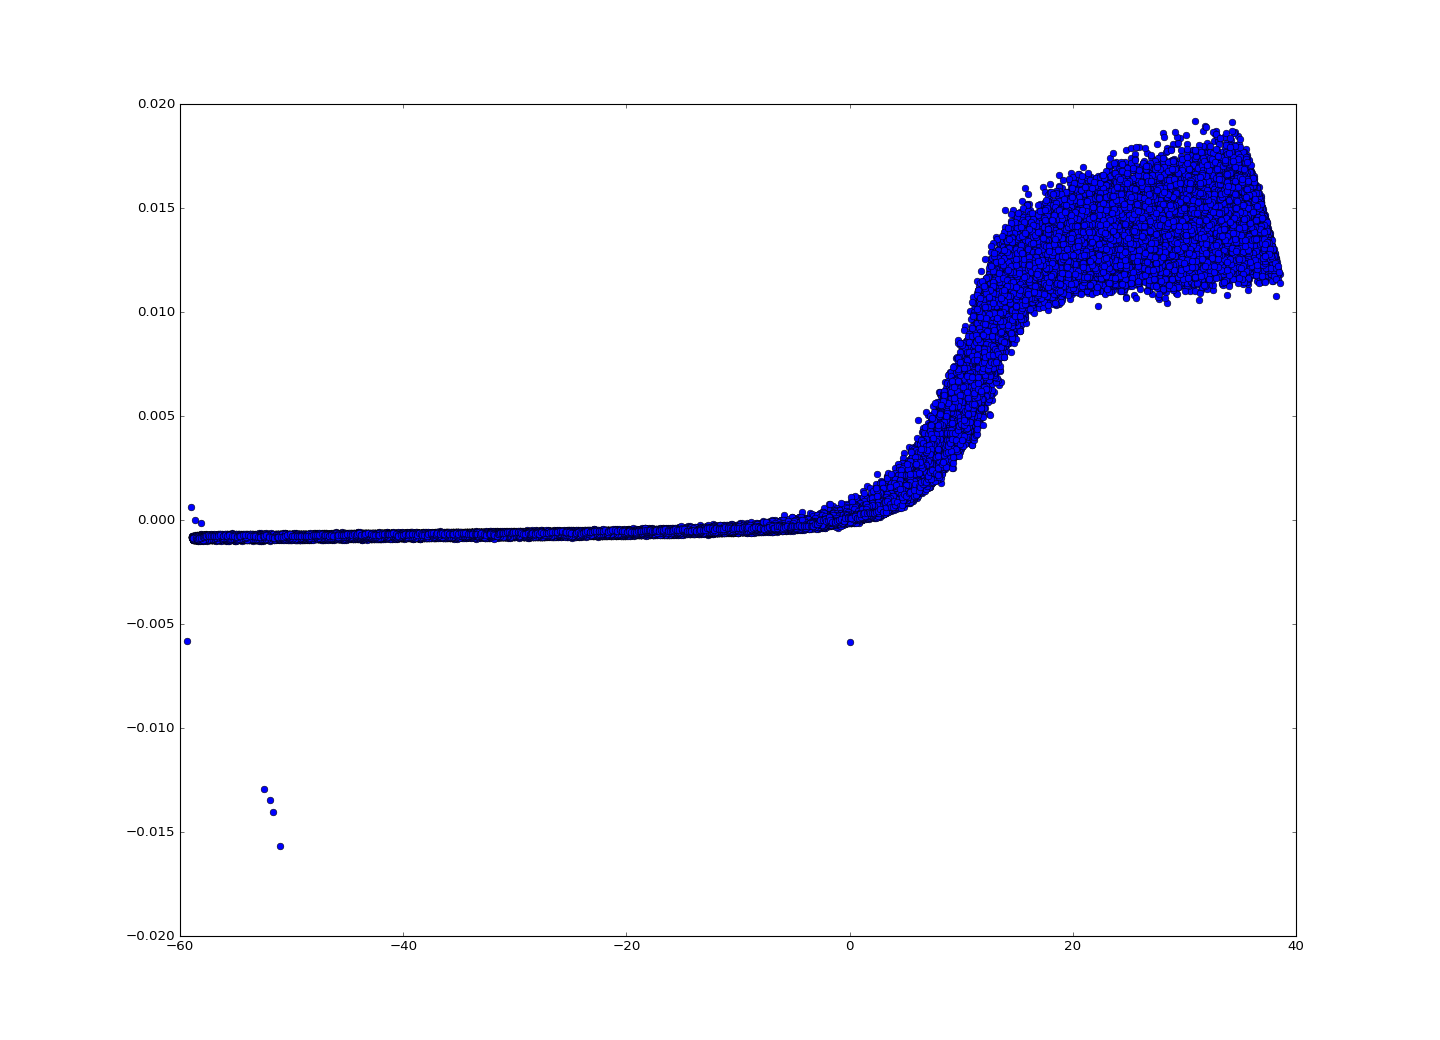

<IPython.core.display.Javascript object>


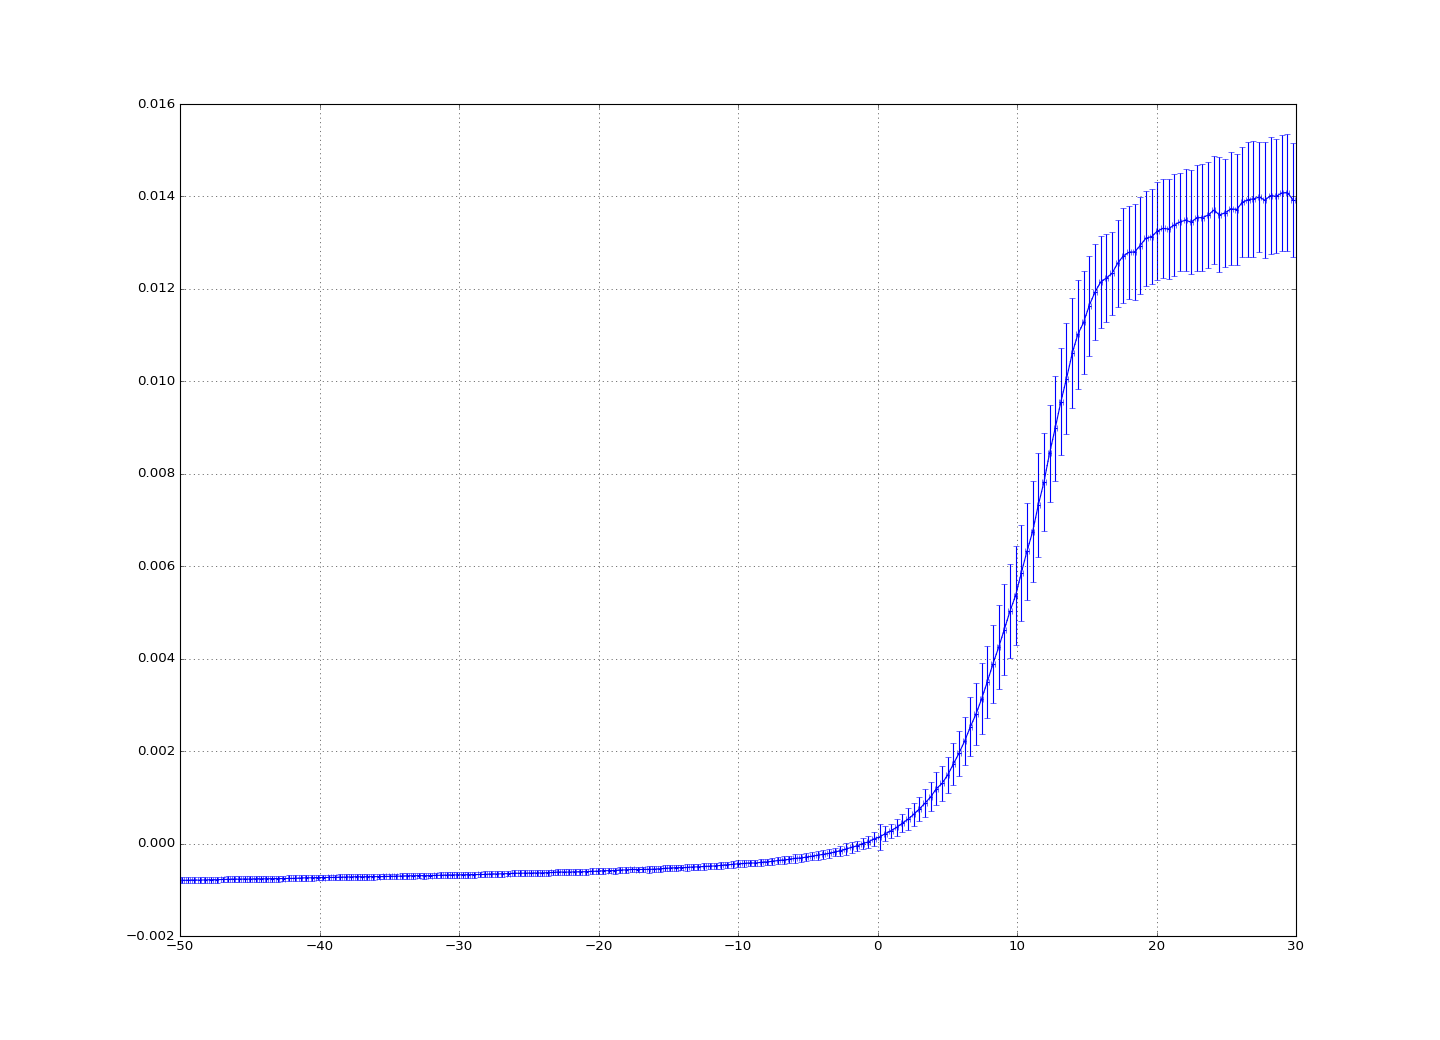

Initial params:
Ionic saturation current = -0.00044 A
Alpha                    = 0.01766
V floating               = -1.06088 V


<IPython.core.display.Javascript object>


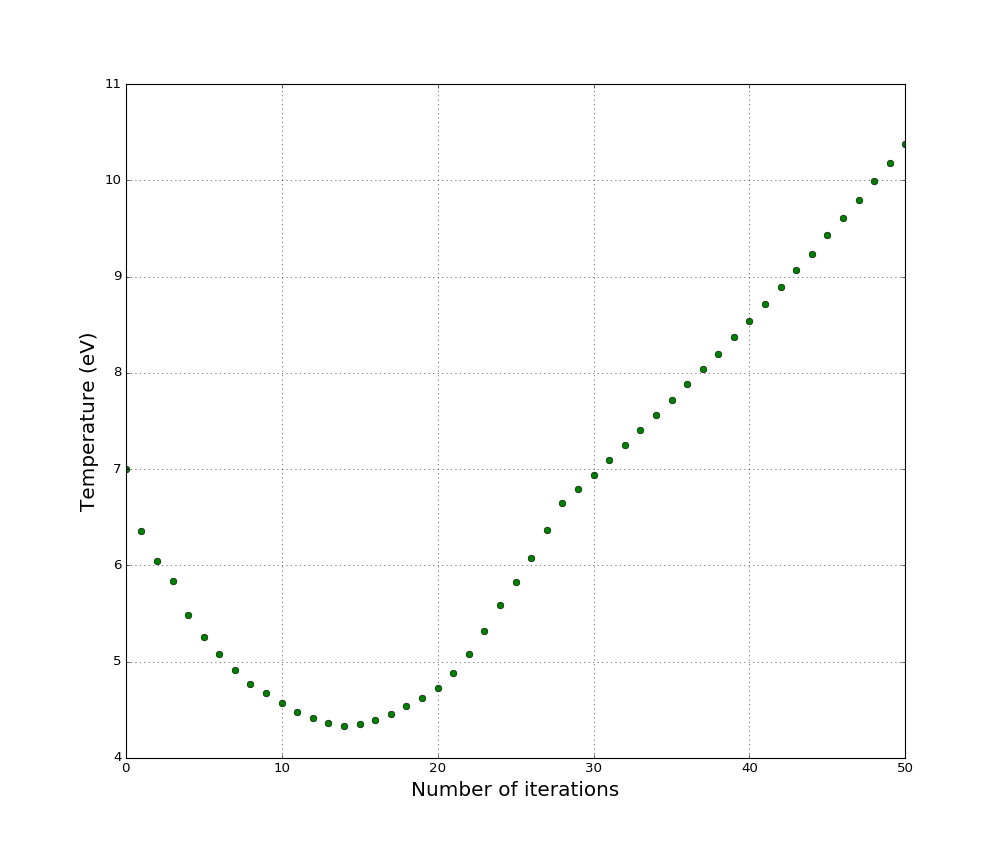

<IPython.core.display.Javascript object>


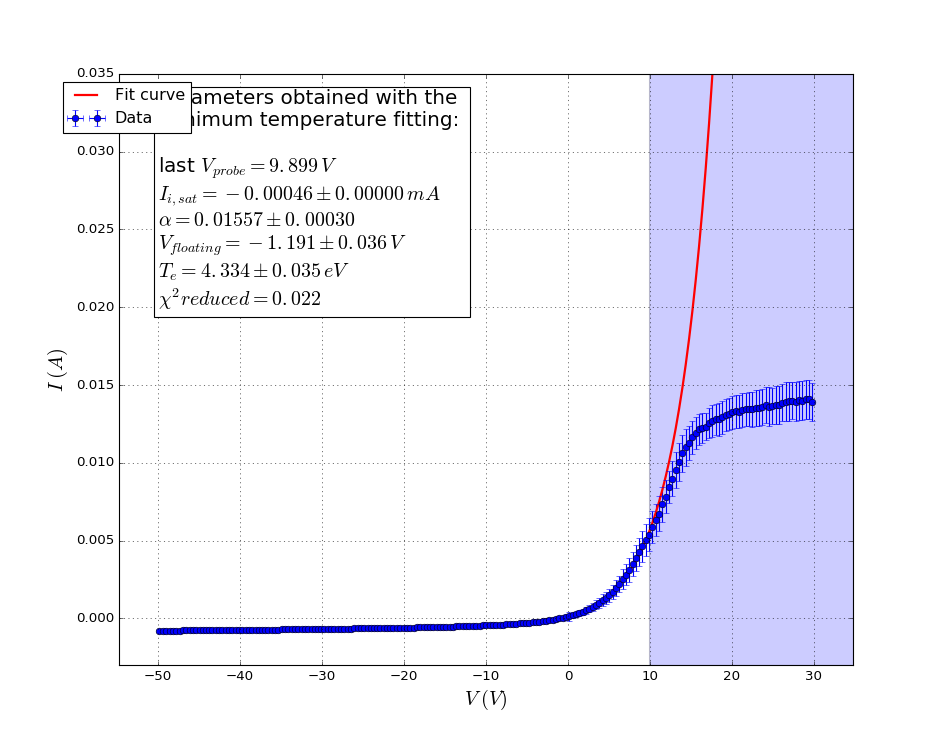


Fitted data:
N. iterations: 50
Minimum temperature found: 4.334220983709471
Correspondent index of iteration: 14
V_probe limit of fit: 9.898527140967166 V

Parameters associated with the lowest temperature:
Ionic saturation current = -0.00046048231479423675 ± 3.1282410589874016e-06 mA
Alpha                    =  0.015571612689409878 ± 0.00030353248769109093
V floating               =  -1.1905232123086524 ± 0.03551962557114975 V
Temp                     =  4.334220983709471 ± 0.03469825231054059
Reduced Chi2             =  0.022
Exec time: 0.24497 s


In [28]:
#now we can add the interface to select intervals and number of bins
#Let's use 3 zones
z1 = widg.FloatSlider(
    value=a,
    min=-60.,
    max=40.,
    step=0.1,
    description='Zone1 Start',
)
z2 = widg.FloatSlider(
    value=b,
    min=-60.,
    max=40.,
    step=0.1,
    description='Zone2 Start',
)
z3 = widg.FloatSlider(
    value=c,
    min=-60.,
    max=40,
    step=0.1,
    description='Cut',
)
nb1 = widg.FloatText(value=b1, description='bin zone1')
nb2 = widg.FloatText(value=b2, description='bin zone2')
n_iter = widg.IntText(value=N_iterations, description='N iter.')
btn_plot = widg.Button(description='Plot')
btn_fit = widg.Button(description='FIT')
cont1 = widg.VBox([z1,z2,z3])
cont2 = widg.VBox([nb1,nb2, widg.HBox([btn_plot,btn_fit, n_iter])])
cont3 = widg.HBox([cont1,cont2])


def handle_plot(sender):
    #creating intervals list
    global intervals
    intervals = [z1.value,z2.value,z3.value]
    global a,b,c, b1,b2 
    a,b,c = intervals  #saving intervals
    n_bins = [nb1.value,nb2.value]
    b1,b2  = n_bins #saving bins
    global bins_data, plt_data
    #plotting raw data
    plt.figure(10, figsize=(18,13))
    plt.errorbar(df['v_probe'], df['i'],fmt='o')
    #elaborating data into bins and getting plot data
    plt_data, bins_data = binning.get_plot_data(df,intervals,n_bins)
    global x,y,xerr,yerr
    x,y,xerr,yerr = plt_data #unpacks data
    #draw the plot
    draw_plot(*plt_data)#parameters unpacking
    
def draw_plot(x, y, xerr, yerr):
    fig = plt.figure(figsize=(18,13))
    plt.grid(True)
    #plt.xlim(-5,10)
    #plt.ylim(-0.01,0.01)
    plt.plot(x,y, ':b')
    plt.errorbar(x,y,yerr, xerr)
    plt.show()
    
def fit(sender):
    global N_iterations
    N_iterations = n_iter.value
    initial_data = fitting.fit_initial_param(
                bins_data, plt_data)
    v_floating, i_ionic_sat, alpha, fig1, out = initial_data
    print('Initial params:')
    print(out)
    global data_fitted
    data_fitted = fitting.fit_data(plt_data, initial_data[:3], N_iterations)
    print('\nFitted data:')
    print('N. iterations: {}'.format(N_iterations))
    print(data_fitted['output_str'])
    print('Exec time: {} s'.format(round(data_fitted['exec_time'],5)))


btn_plot.on_click(handle_plot)
btn_fit.on_click(fit)
display(cont3)
             
